<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a2_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1:

# Student 2:

# Student 3:

# Downloading Data and Preliminaries

In [19]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
from zipfile import ZipFile
import requests
import io

In [20]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_array(zipfile, fn):
    return np.load(io.BytesIO(zipfile[fn]))

In [21]:
"""
This cell loads the training, validation or test data as numpy arrays,
with the positions, initial velocities and charge data of the particles.

The position arrays are shaped as
[simulation id, time point (corresponding to t = 0, 0.5, 1 or 1.5), x/y spatial dimension, particle id].

The initial velocity arrays are shaped as
[simulation id, 1 (corresponding to t=0), x/y spatial dimension, particle id].

The charge arrays are shaped as [simulation id, particle id, 1]

"""

data = load_zip('https://surfdrive.surf.nl/files/index.php/s/OIgda2ZRG8v0eqB/download')

features = ['positions', 'velocities', 'charges']
    
positions_train, velocities_train, charges_train = (load_array(data, f'data/train/{f}.npy') for f in features)
positions_valid, velocities_valid, charges_valid = (load_array(data, f'data/valid/{f}.npy') for f in features)
positions_test, velocities_test, charges_test = (load_array(data, f'data/test/{f}.npy') for f in features)

print('Shapes of the training data:\n')
print(f'positions: {positions_train.shape}')
print(f'velocities: {velocities_train.shape}')
print(f'charges: {charges_train.shape}')

Shapes of the training data:

positions: (10000, 4, 2, 5)
velocities: (10000, 1, 2, 5)
charges: (10000, 5, 1)


In [22]:
a = positions_train[:,0,:,:] #initial positions
a.reshape(10000,10)
np.concatenate((a.reshape(10000,10),velocities_train.reshape(10000,10),charges_train.reshape(10000,5)),axis=1).shape

(10000, 25)

In [23]:
print('An example of retrieving data from the arrays:\n\n')

sim_idx = 42
t_idx = 2  # t_idx 0, 1, 2, 3 corresponds to t=0, 0.5, 1 and 1.5 respectively
spatial_idx = (0,1)  # corresponds to both x and y dimension
particle_idx = 3  # corresponds to particle with index 3

p = positions_train[sim_idx, t_idx, spatial_idx, particle_idx]
v = velocities_train[sim_idx, 0, spatial_idx, particle_idx]  # note: this array contains only the inital velocity -> hence the 0
c = charges_train[sim_idx, particle_idx, 0] 

print(
    f'In simulation {sim_idx} of the training set, particle {particle_idx} with charge {c} had coordinates {p}.\nThe initial velocity of this particle was {v}.'
)

An example of retrieving data from the arrays:


In simulation 42 of the training set, particle 3 with charge -1.0 had coordinates [ 2.05159559 -1.46130851].
The initial velocity of this particle was [ 0.28402364 -0.24784824].


In [24]:
print('Overview of no. datapoints:\n')

print(f'{len(positions_train)} train, {len(positions_valid)} validation, {len(positions_test)} test simulations')

Overview of no. datapoints:

10000 train, 2000 validation, 2000 test simulations


In [25]:
def plot_example(pos, vel):

    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    colors = ['red', 'blue', 'green', 'orange', 'brown']
    for i in range(pos.shape[-1]):
        plt.plot(pos[0, 0, i], pos[0, 1, i], 'd', color=colors[i])
        plt.plot(pos[-1, 0, i], pos[-1, 1, i], 'x', color=colors[i])
        plt.plot([pos[0, 0, i], pos[0, 0, i] + vel[0, 0, i]], [pos[0, 1, i], pos[0, 1, i] + vel[0, 1, i]], '--', color=colors[i])
    fig.set_size_inches(7, 7)
    plt.xlim(np.min(pos)-1, np.max(pos) +1)
    plt.ylim(np.min(pos)-1, np.max(pos) +1)
    plt.plot([], [], 'd', color='black', label='initial position')
    plt.plot([], [], 'x', color='black', label='final position')
    plt.plot([], [], '--', color='black', label='initial velocity \ndirection and magnitude')
    plt.legend()
    
    plt.show()
    return

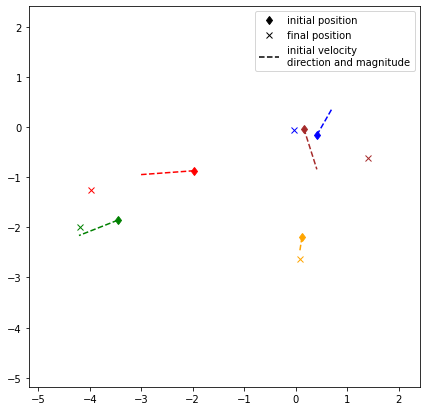

In [26]:
random_idx = np.random.randint(0, 10000)
plot_example(positions_train[random_idx], velocities_train[random_idx])

# Data Handling and Preprocessing

In [27]:
#todo
from torch.utils.data import Dataset, DataLoader,TensorDataset
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [28]:

class DatasetClass(Dataset):
    def __init__(self, positions, velocities,charges):
        
        (samples,seq_length,dim,length) = positions.shape
        # Get the initial positions
        init_pos = positions[:,0,:,:]
        init_pos = init_pos.reshape(samples,dim*length) # Flatten x,y to a single list [x1,x2...,x5,y1,y2...,y5]
        # Get the initial velocities
        init_vel = velocities.reshape(samples,dim*length) # Flatten x,y to a single list [x1,x2...,x5,y1,y2...,y5]
        # Get the charges
        c = charges.reshape(samples,length) # Flatten (samples,1,length) -> (samples,length)
        # Create the feature array using initial state
        features = np.concatenate((init_pos,init_vel,c),axis=1) # Concatenate initial information to a feature array
        
        #Create targets using positions in timesteps after the initial one and flattening the dimensions to a single list
        targets = positions[:,1:,:,:].reshape(samples,seq_length - 1, dim*length)
        
        self.data = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)
        # Sanity checks
        assert features.shape == (samples,dim*length*2 + length)
        assert targets.shape == (samples,seq_length - 1, dim*length)
        
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        

        return x, y
    
    def __len__(self):
        return len(self.data)

In [29]:
train_dataset = DatasetClass(positions_train,velocities_train,charges_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10)
valid_dataset = DatasetClass(positions_valid, velocities_valid, charges_valid)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=10)
test_dataset = DatasetClass(positions_test, velocities_test, charges_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10)

# Model Implementation

In [31]:
#todo

In [55]:
from torch import nn
class LSTMRegressor(nn.Module):

    def __init__(self, input_dim, hidden_dim,output_dim,device):
        super(LSTMRegressor, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.device = device
    
        self.rnn = nn.LSTMCell(input_dim, hidden_dim)
        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        #self.drop = nn.Dropout(p=0.5)
        
        self.criterion = nn.MSELoss()
        
        self.optimizer = torch.optim.Adam(self.parameters())
        

    def forward(self, batch_input):
        
        # input shapes:
        # batch_input: [batch_size, seq_length, input_shape]
        
        # Generate initial hidden and cell states
        hidden0 = torch.randn(batch_input.shape[0], self.hidden_dim).to(self.device)
        c0 = torch.randn(batch_input.shape[0], self.hidden_dim).to(self.device)
        
        # Feed packed input sequence to lstm 
        hidden1, c1 = self.rnn(batch_input,(hidden0,c0))
        hidden2, c2 = self.rnn(batch_input,(hidden1,c1)) # Feed same input to all for now
        hidden3, c3 = self.rnn(batch_input,(hidden2,c2)) # Feed same input to all for now
        
        
        # retrieve final hidden output of last timestep for each sequence
        # shape [batch_size, hidden_dim]
        #last_timestep = out[:,-1]
        
        # apply dropout
        #self.drop(last_timestep)
        
        # feed lstm output to MLP, apply ReLU nonlinearity
        # shape [batch_size, hidden_dim]
        h1 = nn.ReLU()(self.fc1(hidden1))
        output1 = self.fc2(h1)
        h2 = nn.ReLU()(self.fc1(hidden2))
        output2 = self.fc2(h2)
        h3 = nn.ReLU()(self.fc1(hidden3))
        output3 = self.fc2(h3)
        #h = nn.ReLU()(h)
        
        y_preds = torch.stack((output1,output2,output3),axis=1) # (Batch_size,3,dim * length)
        return y_preds

In [43]:
from torch import nn
class LSTMRegressorFeedForward(nn.Module):

    def __init__(self, input_dim, hidden_dim,output_dim,device):
        super(LSTMRegressorFeedForward, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.device = device
    
        self.rnn = nn.LSTMCell(input_dim, hidden_dim)
        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        #self.drop = nn.Dropout(p=0.5)
        
        self.criterion = nn.MSELoss()
        
        self.optimizer = torch.optim.Adam(self.parameters())
        

    def forward(self, batch_input):
        
        # input shapes:
        # batch_input: [batch_size, seq_length, input_shape]
        
        # Generate initial hidden and cell states
        hidden0 = torch.randn(batch_input.shape[0], self.hidden_dim).to(self.device)
        c0 = torch.randn(batch_input.shape[0], self.hidden_dim).to(self.device)
        
        # Feed packed input sequence to lstm 
        hidden1, c1 = self.rnn(batch_input,(hidden0,c0))
        h1 = nn.ReLU()(self.fc1(hidden1))
        output1 = self.fc2(h1)
        
        avg_velocities = (output1 - batch_input[:,:10]) / 0.5
        batch_input2 = torch.cat((output1,avg_velocities,batch_input[:,-5:]),axis=1)
        hidden2, c2 = self.rnn(batch_input2,(hidden1,c1)) # Feed same input to all for now
        h2 = nn.ReLU()(self.fc1(hidden2))
        output2 = self.fc2(h2)
        
        avg_velocities2 = (output2 - batch_input2[:,:10]) / 0.5
        batch_input3 = torch.cat((output2,avg_velocities2,batch_input2[:,-5:]),axis=1)
        hidden3, c3 = self.rnn(batch_input3,(hidden2,c2)) # Feed same input to all for now
        h3 = nn.ReLU()(self.fc1(hidden3))
        output3 = self.fc2(h3)
        
        
        # retrieve final hidden output of last timestep for each sequence
        # shape [batch_size, hidden_dim]
        #last_timestep = out[:,-1]
        
        # apply dropout
        #self.drop(last_timestep)
        
        # feed lstm output to MLP, apply ReLU nonlinearity
        # shape [batch_size, hidden_dim]
        
        #h = nn.ReLU()(h)
        
        y_preds = torch.stack((output1,output2,output3),axis=1) # (Batch_size,3,dim * length)
        return y_preds

# Model Training

In [13]:
def save_model_checkpoint(path, model, optimizer, val_loss, val_acc, train_acc, train_loss ):
    if path == None:
        return print("Kindly define a path")
    path = path
    
    save_dict = {"model_dict" : model.state_dict(), 
                 "optimizer_dict": optimizer.state_dict(),
                 "val_loss_dict": val_loss,
                 "val_acc_dict": val_acc,
                 "train_acc_dict": train_acc,
                 "train_loss_dict": train_loss}
    torch.save(save_dict, path)
    return print("Model Saved to ==> {}".format(path))

In [14]:
# training and validation after every epoch
def train(model, train_loader, val_loader, criterion, num_epochs, save_name):
    best_val_loss = float("Inf") 
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    cur_step = 0
    train_pred = []
    val_pred = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_train_acc = 0.0
  
        model.train()
        print("Starting epoch " + str(epoch+1))
        for train_data, targets in train_loader:
            
           
            # Forward
            input_tensor = train_data.to(device)
            outputs = model.forward(input_tensor)
            loss = criterion(outputs,targets.to(device))
            
                
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()   
            running_loss += loss
          

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print("Train Pass Completed")

        ########################################|Validation Set|#############################################
        val_running_loss = 0.0
        with torch.no_grad():
            model.eval()
            for val_data, val_targets in val_loader:
                input_tensor = val_data.to(device)
                outputs = model.forward(input_tensor)
                loss = criterion(outputs,val_targets.to(device))
                val_running_loss += loss

        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        
        print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}' 
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss 
            save_model_checkpoint(save_name, model, optimizer, best_val_loss, 0, 0, avg_train_loss )
    
    print("Finished Training") 
    return train_losses, val_losses
     

In [58]:
LSTM_reg = LSTMRegressor(25,192,10,device='cuda:0').cuda()

optimizer = torch.optim.SGD(LSTM_reg.parameters(), lr=0.01, momentum=0.9)
num_epochs = 100
save_name = f'LSTM_reg.pt'
criterion = nn.MSELoss()

obtained_train_loss, obtained_val_loss = train(LSTM_reg, 
                                                      train_loader, valid_loader, criterion, num_epochs, save_name)

Starting epoch 1
Train Pass Completed
Epoch [1/100],Train Loss: 1.7338, Valid Loss: 0.56551653
Model Saved to ==> LSTM_reg.pt
Starting epoch 2
Train Pass Completed
Epoch [2/100],Train Loss: 0.5043, Valid Loss: 0.43483043
Model Saved to ==> LSTM_reg.pt
Starting epoch 3
Train Pass Completed
Epoch [3/100],Train Loss: 0.4045, Valid Loss: 0.38587406
Model Saved to ==> LSTM_reg.pt
Starting epoch 4
Train Pass Completed
Epoch [4/100],Train Loss: 0.3471, Valid Loss: 0.34214899
Model Saved to ==> LSTM_reg.pt
Starting epoch 5
Train Pass Completed
Epoch [5/100],Train Loss: 0.3065, Valid Loss: 0.31607971
Model Saved to ==> LSTM_reg.pt
Starting epoch 6
Train Pass Completed
Epoch [6/100],Train Loss: 0.2791, Valid Loss: 0.29593742
Model Saved to ==> LSTM_reg.pt
Starting epoch 7
Train Pass Completed
Epoch [7/100],Train Loss: 0.2561, Valid Loss: 0.27490342
Model Saved to ==> LSTM_reg.pt
Starting epoch 8
Train Pass Completed
Epoch [8/100],Train Loss: 0.2387, Valid Loss: 0.25953364
Model Saved to ==> LSTM

Train Pass Completed
Epoch [70/100],Train Loss: 0.1014, Valid Loss: 0.16614254
Model Saved to ==> LSTM_reg.pt
Starting epoch 71
Train Pass Completed
Epoch [71/100],Train Loss: 0.1010, Valid Loss: 0.16670536
Starting epoch 72
Train Pass Completed
Epoch [72/100],Train Loss: 0.1000, Valid Loss: 0.16573808
Model Saved to ==> LSTM_reg.pt
Starting epoch 73
Train Pass Completed
Epoch [73/100],Train Loss: 0.0997, Valid Loss: 0.16699180
Starting epoch 74
Train Pass Completed
Epoch [74/100],Train Loss: 0.0995, Valid Loss: 0.16705044
Starting epoch 75
Train Pass Completed
Epoch [75/100],Train Loss: 0.0990, Valid Loss: 0.16674715
Starting epoch 76
Train Pass Completed
Epoch [76/100],Train Loss: 0.0985, Valid Loss: 0.16640814
Starting epoch 77
Train Pass Completed
Epoch [77/100],Train Loss: 0.0981, Valid Loss: 0.16520455
Model Saved to ==> LSTM_reg.pt
Starting epoch 78
Train Pass Completed
Epoch [78/100],Train Loss: 0.0977, Valid Loss: 0.16619679
Starting epoch 79
Train Pass Completed
Epoch [79/100

In [44]:
LSTM_reg_ff = LSTMRegressorFeedForward(25,192,10,device='cuda:0').cuda()

optimizer = torch.optim.SGD(LSTM_reg_ff.parameters(), lr=0.01, momentum=0.9)
num_epochs = 100
save_name = f'LSTM_reg_ff.pt'
criterion = nn.MSELoss()

obtained_train_loss, obtained_val_loss = train(LSTM_reg_ff, 
                                                      train_loader, valid_loader, criterion, num_epochs, save_name)

Starting epoch 1
Train Pass Completed
Epoch [1/100],Train Loss: 2.9493, Valid Loss: 1.29062331
Model Saved to ==> LSTM_reg_ff.pt
Starting epoch 2
Train Pass Completed
Epoch [2/100],Train Loss: 1.1049, Valid Loss: 0.92549068
Model Saved to ==> LSTM_reg_ff.pt
Starting epoch 3
Train Pass Completed
Epoch [3/100],Train Loss: 0.7987, Valid Loss: 0.68528670
Model Saved to ==> LSTM_reg_ff.pt
Starting epoch 4
Train Pass Completed
Epoch [4/100],Train Loss: 0.6311, Valid Loss: 0.58944482
Model Saved to ==> LSTM_reg_ff.pt
Starting epoch 5
Train Pass Completed
Epoch [5/100],Train Loss: 0.5417, Valid Loss: 0.52197975
Model Saved to ==> LSTM_reg_ff.pt
Starting epoch 6
Train Pass Completed
Epoch [6/100],Train Loss: 0.4797, Valid Loss: 0.48037547
Model Saved to ==> LSTM_reg_ff.pt
Starting epoch 7
Train Pass Completed
Epoch [7/100],Train Loss: 0.4292, Valid Loss: 0.43565467
Model Saved to ==> LSTM_reg_ff.pt
Starting epoch 8
Train Pass Completed
Epoch [8/100],Train Loss: 0.3978, Valid Loss: 0.41503748
Mo

Train Pass Completed
Epoch [72/100],Train Loss: 0.1541, Valid Loss: 0.23342770
Model Saved to ==> LSTM_reg_ff.pt
Starting epoch 73
Train Pass Completed
Epoch [73/100],Train Loss: 0.1524, Valid Loss: 0.23360404
Starting epoch 74
Train Pass Completed
Epoch [74/100],Train Loss: 0.1516, Valid Loss: 0.23012914
Model Saved to ==> LSTM_reg_ff.pt
Starting epoch 75
Train Pass Completed
Epoch [75/100],Train Loss: 0.1514, Valid Loss: 0.23431210
Starting epoch 76
Train Pass Completed
Epoch [76/100],Train Loss: 0.1510, Valid Loss: 0.23052359
Starting epoch 77
Train Pass Completed
Epoch [77/100],Train Loss: 0.1504, Valid Loss: 0.23349459
Starting epoch 78
Train Pass Completed
Epoch [78/100],Train Loss: 0.1488, Valid Loss: 0.23225616
Starting epoch 79
Train Pass Completed
Epoch [79/100],Train Loss: 0.1467, Valid Loss: 0.23099835
Starting epoch 80
Train Pass Completed
Epoch [80/100],Train Loss: 0.1467, Valid Loss: 0.23157686
Starting epoch 81
Train Pass Completed
Epoch [81/100],Train Loss: 0.1461, Val

# Evaluation

In [ ]:
#todo

In [37]:
#Evaluating on the validation set

def evaluate(model, test_loader,device='cpu'):
    val_running_loss = 0.0
    preds = []
    actual = []
    with torch.no_grad():
        model.eval()
        for val_data, val_targets in test_loader:
            input_tensor = val_data.to(device)
            outputs = model.forward(input_tensor)
            preds.append(outputs)
            actual.append(val_targets)
            loss = criterion(outputs,val_targets.to(device))
            val_running_loss += loss

        avg_val_loss = val_running_loss / len(test_loader)
        print("Average Test Loss: {:4f}".format(avg_val_loss))
        return preds,actual

In [40]:
#Model Evaluation
model = LSTMRegressorFeedForward(25,192,10,'cpu')
checkpoint = torch.load('LSTM_reg_ff.pt', map_location = 'cpu')
model.load_state_dict(checkpoint['model_dict'])

preds,actual = evaluate(model, test_loader)

Average Test Loss: 0.222947


In [62]:
def plot_positions(preds_sample, actual_sample):

    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    colors = ['red', 'blue', 'green', 'orange', 'brown']
    for i in range(5):
        plt.plot(preds_sample[i],preds_sample[i+5],'o',color=colors[i])
        plt.plot(actual_sample[i],actual_sample[i+5],'x',color=colors[i])
    fig.set_size_inches(7, 7)
    plt.legend()
    
    plt.show()
    return

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


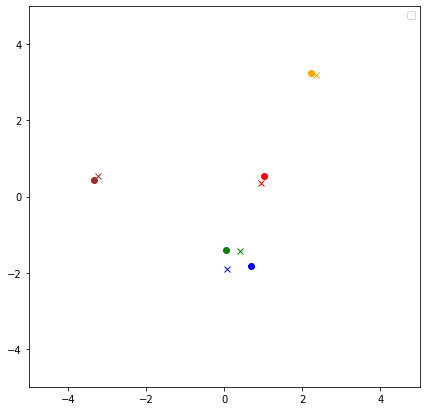

In [63]:
plot_positions(preds[0][0][0], actual[0][0][0])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


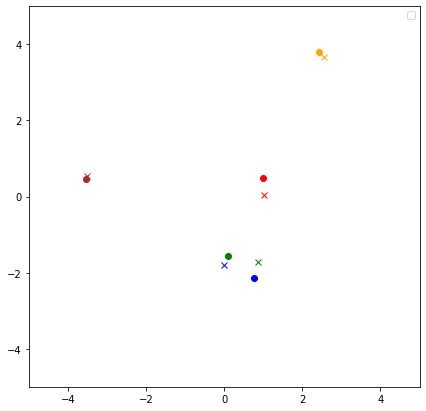

In [64]:
plot_positions(preds[0][0][1], actual[0][0][1])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


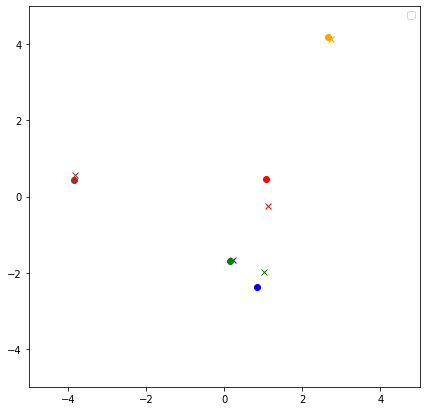

In [65]:
plot_positions(preds[0][0][2], actual[0][0][2])